# 环境导入与基本配置

In [1]:
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import warnings

warnings.filterwarnings('ignore')  # 忽略无关警告，保持输出整洁

# 设置中文字体支持（解决matplotlib中文显示问题）
plt.rcParams["font.family"] = ["SimSun"]  # 设置宋体
plt.rcParams['axes.unicode_minus'] = False

# 1. 路网密度

正在从OpenStreetMap下载 'Manhattan, New York City' 的驾驶路网数据...
路网下载完成！图结构统计：
- 节点数量：4619
- 边数量：9900


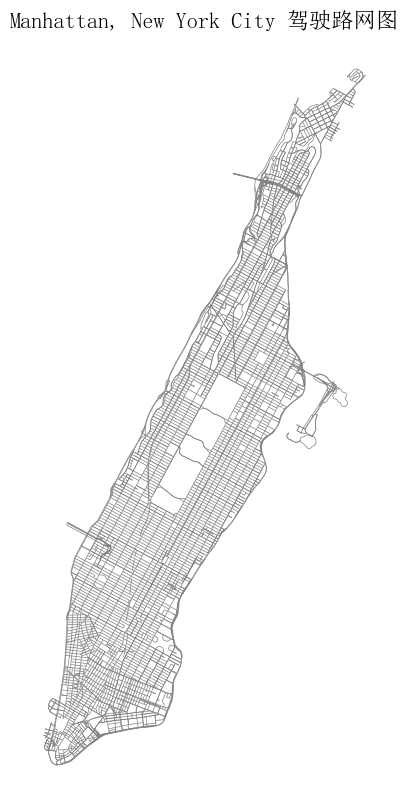

In [2]:


# 1. 定义研究区域（可替换为任意城市/区域，如"Beijing, China"）
place_name = "Manhattan, New York City"
print(f"正在从OpenStreetMap下载 '{place_name}' 的驾驶路网数据...")

# 2. 下载驾驶路网（network_type可选：drive/walk/bike/all）
G = ox.graph_from_place(place_name, network_type='drive')
print(f"路网下载完成！图结构统计：")
print(f"- 节点数量：{G.number_of_nodes()}")
print(f"- 边数量：{G.number_of_edges()}")

# 3. 投影转换（将经纬度坐标系转为UTM坐标系，使长度单位为"米"）
G_proj = ox.project_graph(G)

# 4. 可视化路网
fig, ax = ox.plot_graph(
    G_proj,
    bgcolor="#FFFFFF",        # 背景色：白色
    edge_color="gray",       # 道路颜色：灰色
    node_size=0,             # 隐藏节点（避免画面杂乱）
    edge_linewidth=0.5,      # 道路线宽
    show=False,              # 不自动显示（后续统一控制）
    close=False              # 不自动关闭画布
)

# 添加标题与显示
ax.set_title(f'{place_name} 驾驶路网图', fontsize=16, pad=20)
plt.tight_layout()  # 自动调整布局
plt.show()

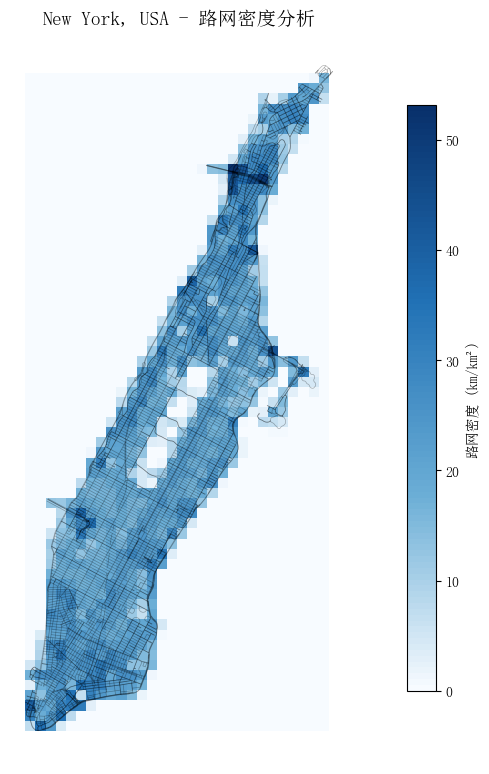

路网密度统计 (排除空网格):
  有效网格数量: 694 / 1950
  最小值: 0.11 km/km²
  最大值: 53.12 km/km²
  平均值: 18.77 km/km²
  中位数: 19.74 km/km²
  标准差: 8.41 km/km²


In [12]:
def analyze_network_density_and_blocks(G, place_name="研究区域"):
    """
    分析路网密度 - 修正版本
    """
    # 首先将图转换为投影坐标系（UTM）
    G_proj = ox.project_graph(G)
    
    # 获取路网的边界
    bounds = ox.graph_to_gdfs(G_proj, nodes=False).total_bounds  # west, south, east, north
    
    # 创建网格
    grid_size = 300  # 网格大小（米）
    west, south, east, north = bounds
    x_coords = np.arange(west, east, grid_size)
    y_coords = np.arange(south, north, grid_size)
    
    # 计算每个网格的路网密度
    road_densities = []
    grid_polygons = []
    
    # 将图转换为GeoDataFrame
    nodes, edges = ox.graph_to_gdfs(G_proj)
    
    # 确保几何类型是LineString或MultiLineString
    edges = edges[edges.geometry.type.isin(['LineString', 'MultiLineString'])]
    
    for i in range(len(x_coords)-1):
        for j in range(len(y_coords)-1):
            # 创建网格多边形
            poly = Polygon([
                (x_coords[i], y_coords[j]),
                (x_coords[i+1], y_coords[j]),
                (x_coords[i+1], y_coords[j+1]),
                (x_coords[i], y_coords[j+1])
            ])
            
            total_road_length_in_grid = 0
            
            # 对每条道路计算与网格的交集长度
            for idx, road in edges.iterrows():
                try:
                    # 计算道路与网格的交集
                    intersection = road.geometry.intersection(poly)
                    
                    if not intersection.is_empty:
                        # 计算交集部分的长度
                        if intersection.geom_type == 'LineString':
                            total_road_length_in_grid += intersection.length
                        elif intersection.geom_type == 'MultiLineString':
                            for line in intersection.geoms:
                                total_road_length_in_grid += line.length
                except Exception as e:
                    # 处理可能的几何错误
                    print(f"处理道路 {idx} 时出错: {e}")
                    continue
            
            # 计算路网密度 (km/km²)
            grid_area = grid_size * grid_size / 1000000  # 转换为平方公里
            road_density = total_road_length_in_grid / 1000 / grid_area  # 公里/平方公里
            
            road_densities.append(road_density)
            grid_polygons.append(poly)
    
    # 创建路网密度热力图
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # 路网密度可视化
    grid_gdf = gpd.GeoDataFrame({'density': road_densities}, 
                               geometry=grid_polygons, crs=edges.crs)
    
    # 创建自定义颜色映射
    colors = ['#f7fbff', '#6baed6', '#2171b5', '#08306b']
    cmap = LinearSegmentedColormap.from_list('road_density', colors, N=100)
    
    # 绘制密度图
    grid_gdf.plot(column='density', cmap=cmap, ax=ax, legend=True,
                 legend_kwds={'label': '路网密度 (km/km²)', 'shrink': 0.8})
    
    # 绘制原始路网
    edges.plot(ax=ax, color='black', linewidth=0.5, alpha=0.3)
    ax.set_title(f'{place_name} - 路网密度分析', fontsize=14, fontweight='bold')
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    # 过滤掉密度为0的网格
    non_zero_density = grid_gdf[grid_gdf['density'] > 0]['density']
    
    print(f"路网密度统计 (排除空网格):")
    print(f"  有效网格数量: {len(non_zero_density)} / {len(grid_gdf)}")
    print(f"  最小值: {non_zero_density.min():.2f} km/km²")
    print(f"  最大值: {non_zero_density.max():.2f} km/km²")
    print(f"  平均值: {non_zero_density.mean():.2f} km/km²")
    print(f"  中位数: {non_zero_density.median():.2f} km/km²")
    print(f"  标准差: {non_zero_density.std():.2f} km/km²")
    
    return grid_gdf

# 使用示例
grid_density = analyze_network_density_and_blocks(G, "New York, USA")


## 持久化存储

In [10]:
# 保存为 GeoPackage
grid_density.to_file("200new_york_road_density.gpkg", layer='road_density', driver='GPKG')
print("已保存为 GeoPackage 文件")

# 读取
grid_density_loaded = gpd.read_file("200new_york_road_density.gpkg", layer='road_density')

# # 保存为 Shapefile
# grid_density.to_file("200new_york_road_density.shp")
# print("已保存为 Shapefile")

# # 读取
# grid_density_loaded = gpd.read_file("200new_york_road_density.shp")

# 保存为 GeoJSON
grid_density.to_file("200new_york_road_density.geojson", driver='GeoJSON')
print("已保存为 GeoJSON")

# 读取
grid_density_loaded = gpd.read_file("new_york_road_density.geojson")


已保存为 GeoPackage 文件
已保存为 GeoJSON
